In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
from skimage import color
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import rotate, rescale
from skimage.util import random_noise
from sklearn.decomposition import PCA
from google.colab.patches import cv2_imshow
from PIL import Image

In [3]:
image1_path = r'/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/img1.png'
image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
image2_path = r'/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/img2.png'
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)


In [4]:
num_octaves = 3
num_intervals = s = 2
sub_intervals = num_intervals + 3
sigma = 0.707

In [5]:
image1 = skimage.img_as_float(image1)
image2 = skimage.img_as_float(image2)
# Scale the image
scaled_factor = 0.5
scaled_image1 = rescale(image1, scaled_factor, anti_aliasing=False)
scaled_image2 = rescale(image2, scaled_factor, anti_aliasing=False)
# Rotate the image
rotation_angle = 45
rotated_image1 = rotate(image1, angle=rotation_angle)
rotated_image2 = rotate(image2, angle=rotation_angle)
# Blur the image
sigma_blur = 2
blurred_image1 = gaussian_filter(image1, sigma=sigma_blur)
blurred_image2 = gaussian_filter(image2, sigma=sigma_blur)

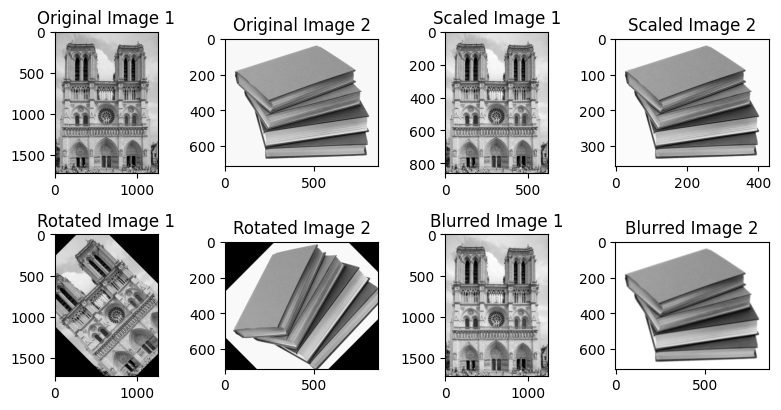

In [6]:
# Display the images side by side and line by line
plt.figure(figsize=(8,6))

# Original images
plt.subplot(3, 4, 1)
plt.imshow(image1, cmap='gray')
plt.title('Original Image 1')

plt.subplot(3, 4, 2)
plt.imshow(image2, cmap='gray')
plt.title('Original Image 2')

# Scaled images
plt.subplot(3, 4, 3)
plt.imshow(scaled_image1, cmap='gray')
plt.title('Scaled Image 1')

plt.subplot(3, 4, 4)
plt.imshow(scaled_image2, cmap='gray')
plt.title('Scaled Image 2')

# Rotated images
plt.subplot(3, 4, 5)
plt.imshow(rotated_image1, cmap='gray')
plt.title('Rotated Image 1')

plt.subplot(3, 4, 6)
plt.imshow(rotated_image2, cmap='gray')
plt.title('Rotated Image 2')

# Blurred images
plt.subplot(3, 4, 7)
plt.imshow(blurred_image1, cmap='gray')
plt.title('Blurred Image 1')

plt.subplot(3, 4, 8)
plt.imshow(blurred_image2, cmap='gray')
plt.title('Blurred Image 2')

plt.tight_layout()
plt.show()

In [7]:
def create_octaves(image,intervals,sub_intervals,sigma):
  k=2**(1/intervals)
  original_image=image
  num_octaves = 3
  scales_per_octave =sub_intervals
  # List to store images from all octaves
  scale_space_pyramid = []
  for octave in range(num_octaves):
    octave_images=[]
    for j in range(scales_per_octave):
      # Apply Gaussian blurring to the original image at each scale
      blurred_image = cv2.GaussianBlur(original_image, (0, 0), sigmaX=((k ** j)) * sigma, sigmaY=((k ** j)) * sigma)
      # Store the blurred image
      octave_images.append(blurred_image)

    # Store the images from the current octave in the overall scale space pyramid
    scale_space_pyramid.append(octave_images)
    # Downsample the original image for the next octave
    original_image = cv2.resize(original_image, (original_image.shape[1] // 2, original_image.shape[0] // 2))

  # Accessing and Displaying images from the scale space pyramid
  for octave, octave_images in enumerate(scale_space_pyramid):
    # Number of scales in the current octave
      num_scales = len(octave_images)
    # Create subplots for the current octave
      fig, axes = plt.subplots(1, num_scales, figsize=(10,5))
      for scale, image in enumerate(octave_images):
          # Display image with title
        axes[scale].imshow(image, cmap='gray')
        axes[scale].set_title(f"Octave {octave + 1}, Scale {scale + 1}")
        axes[scale].axis('off')  # Turn off axis labels

  return scale_space_pyramid

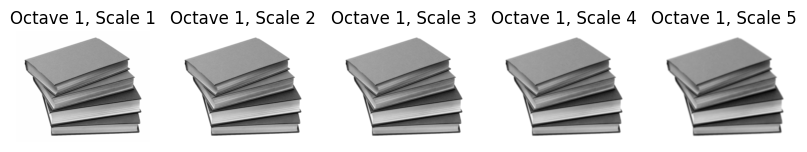

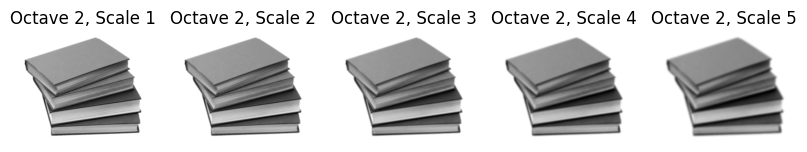

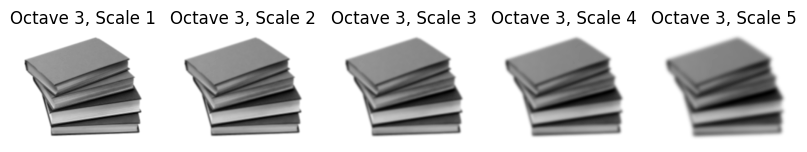

In [8]:
octaves_pyramid = create_octaves(image2, num_intervals, sub_intervals, sigma)

In [9]:
def generate_dog_images(octaves_pyramid,s):
# Generate DoG images for each octave
  dog_pyramid = []
  for octave_images in octaves_pyramid:
      # Initialize a list to store DoG images for the current octave
      octave_dog_images = []
      # Subtract adjacent scales to create DoG images
      for i in range(4):
          dog_image = octave_images[i + 1] - octave_images[i]
          octave_dog_images.append(dog_image)

      # Append the DoG images for the current octave to the overall DoG pyramid
      dog_pyramid.append(octave_dog_images)

  for octave, octave_dog_images in enumerate(dog_pyramid):
      # Number of DoG images in the current octave
      num_dog_images = len(octave_dog_images)

      # Create subplots for the current octave
      fig, axes = plt.subplots(1, num_dog_images, figsize=(10, 5))

      for scale, dog_image in enumerate(octave_dog_images):
          # Display DoG image with title
          axes[scale].imshow(dog_image, cmap='gray')
          axes[scale].set_title(f"Octave {octave + 1}, DoG Scale {scale + 1}")
          axes[scale].axis('off')  # Turn off axis labels

      plt.show()


  return dog_pyramid


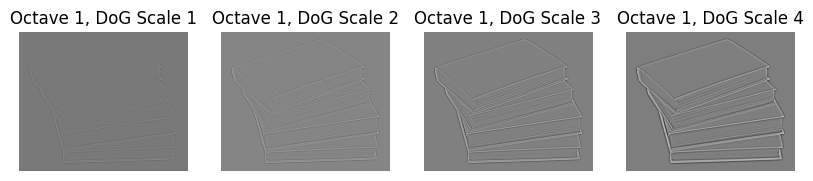

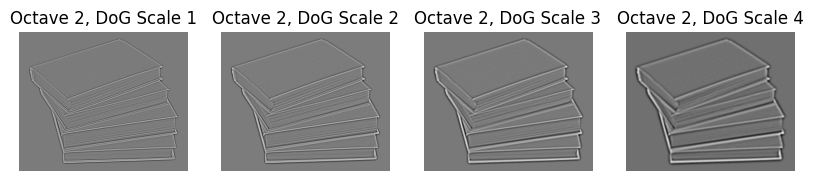

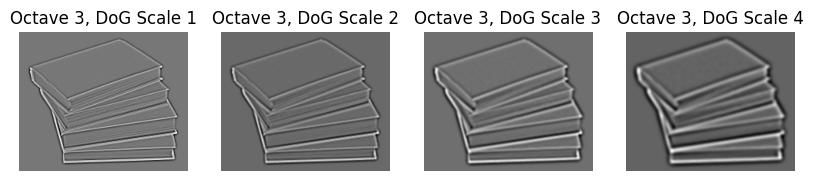

In [10]:
dog_pyramid = generate_dog_images(octaves_pyramid, s)

In [11]:
def detect_keypoints(dog_pyramid):
    keypoints = []

    for octave, octave_dog_images in enumerate(dog_pyramid):
        for scale in range(1, len(octave_dog_images) - 1):
            current_dog = octave_dog_images[scale]
            dog_above = octave_dog_images[scale + 1]
            dog_below = octave_dog_images[scale - 1]

            # Check if the pixel is a local extremum
            for i in range(1, current_dog.shape[0] - 1):
                for j in range(1, current_dog.shape[1] - 1):
                    pixel_value = current_dog[i, j]
                    # Neighboring values for local maxima and minima
                    max_neighborhood_current = current_dog[i - 1:i + 2, j - 1:j + 2].max()
                    min_neighborhood_current = current_dog[i - 1:i + 2, j - 1:j + 2].min()
                    # Neighboring maxima and minima in above dog image
                    max_neighborhood_above = dog_above[i - 1:i + 2, j - 1:j + 2].max()
                    min_neighborhood_above = dog_above[i - 1:i + 2, j - 1:j + 2].min()
                    # Neighboring maxima and minima in bellow dog image
                    max_neighborhood_below = dog_below[i - 1:i + 2, j - 1:j + 2].max()
                    min_neighborhood_below = dog_below[i - 1:i + 2, j - 1:j + 2].min()

                    if ((pixel_value>0.001 and pixel_value>=max_neighborhood_current and
                         pixel_value>max_neighborhood_above and pixel_value>max_neighborhood_below)
                        or(pixel_value<-0.001 and pixel_value<=min_neighborhood_current and
                           pixel_value<min_neighborhood_above and pixel_value<min_neighborhood_below)
                    ):
                        keypoints.append((octave, scale, i, j))

    return keypoints

In [12]:
keypoints= detect_keypoints(dog_pyramid)
print(f"Number of keypoints detected: {len(keypoints)}")

Number of keypoints detected: 6117


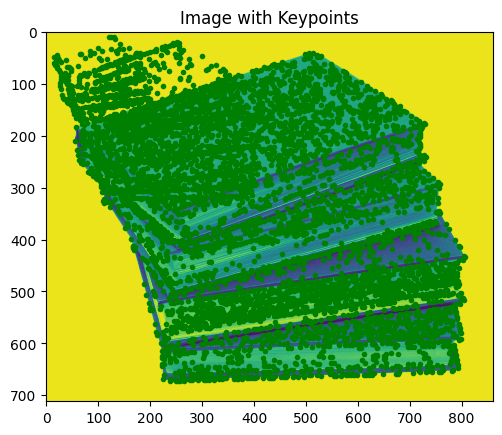

In [13]:
#image_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Plot a dot at each keypoint
for octave, scale, i, j in keypoints:
  plt.scatter(j, i, marker='.', color='g')

# Display the image with keypoints
plt.imshow(image2)
plt.title("Image with Keypoints")
plt.show()


In [74]:
image = (Image.open('/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_1/img2.png')).convert('L')
image_array = np.array(image, dtype=float)
width, height = image.size


In [93]:
def calculate_gradients(image):
    # Calculate gradients (dx, dy) using Sobel operators
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(dx**2 + dy**2)
    grad_dir = np.arctan2(dy, dx)
    return dx, dy, grad_mag, grad_dir

def get_keypoint_feature_list(keypoints, dog_pyramid):
    list_keypoint_feature = []

    for keypoint in keypoints:
        octave, scale, x, y = keypoint

        if 20 <= x < height - 20 and 20 <= y < width - 20:
            # Finding orientation
            sigma_orientation = 20.0
            dog_image = dog_pyramid[octave][scale]
            grad_x, grad_y, grad_mag, grad_dir = calculate_gradients(dog_image)

            window = grad_dir[x - 20:x + 21, y - 20:y + 21]
            grad_mag_window = grad_mag[x - 20:x + 21, y - 20:y + 21]

            histo = np.zeros(40)
            for i in range(41):
                for j in range(41):
                  print(i, j, window.shape);
                  histo[int(window[i][j] // 10)] += (grad_mag_window[i][j] * np.exp(-((i-20)**2 + (j-20)**2)/(2*(sigma**2)) ));
            keypoint_orient = np.argmax(histo) * 10;
            # print(histo);

            #finding descriptors
            patch_16x16_dir = grad_dir[x-8:x+9, y-8:y+9] - keypoint_orient;
            patch_16x16_mag = grad_mag[x-8:x+9, y-8:y+9];
            hist_vector = []
            for i in range(4):
              for j in range(4):
                histo_8 = np.zeros(8);
                patch_4x4_dir = patch_16x16_dir[4*i : 4*(i+1), 4*j : 4*(j+1)];
                patch_4x4_mag = patch_16x16_mag[4*i : 4*(i+1), 4*j : 4*(j+1)];
                for row in range(4):
                  for col in range(4):
                    histo_8[int((patch_4x4_dir[row][col] - keypoint_orient) // 45) % 8] += (patch_4x4_mag[row][col] * np.exp(-((2*i + row - 8)**2 + (2*j + col - 8)**2)/(2*(sigma**2)) ))


                hist_vector = hist_vector + histo_8.tolist();

            list_keypoint_feature.append([octave, scale, x, y, hist_vector]);

    return list_keypoint_feature;

In [94]:
descriptors = get_keypoint_feature_list(keypoints, dog_pyramid)

Streaming output truncated to the last 5000 lines.
20 21 (41, 41)
20 22 (41, 41)
20 23 (41, 41)
20 24 (41, 41)
20 25 (41, 41)
20 26 (41, 41)
20 27 (41, 41)
20 28 (41, 41)
20 29 (41, 41)
20 30 (41, 41)
20 31 (41, 41)
20 32 (41, 41)
20 33 (41, 41)
20 34 (41, 41)
20 35 (41, 41)
20 36 (41, 41)
20 37 (41, 41)
20 38 (41, 41)
20 39 (41, 41)
20 40 (41, 41)
21 0 (41, 41)
21 1 (41, 41)
21 2 (41, 41)
21 3 (41, 41)
21 4 (41, 41)
21 5 (41, 41)
21 6 (41, 41)
21 7 (41, 41)
21 8 (41, 41)
21 9 (41, 41)
21 10 (41, 41)
21 11 (41, 41)
21 12 (41, 41)
21 13 (41, 41)
21 14 (41, 41)
21 15 (41, 41)
21 16 (41, 41)
21 17 (41, 41)
21 18 (41, 41)
21 19 (41, 41)
21 20 (41, 41)
21 21 (41, 41)
21 22 (41, 41)
21 23 (41, 41)
21 24 (41, 41)
21 25 (41, 41)
21 26 (41, 41)
21 27 (41, 41)
21 28 (41, 41)
21 29 (41, 41)
21 30 (41, 41)
21 31 (41, 41)
21 32 (41, 41)
21 33 (41, 41)
21 34 (41, 41)
21 35 (41, 41)
21 36 (41, 41)
21 37 (41, 41)
21 38 (41, 41)
21 39 (41, 41)
21 40 (41, 41)
22 0 (41, 41)
22 1 (41, 41)
22 2 (41, 41)
22

KeyboardInterrupt: 

In [ ]:
desc_matrix = np.vstack(descriptors)

In [ ]:
def do_pca_sift(descriptors, desc_matrix, n_comps):
    pca = PCA(n_components=n_comps)
    pca.fit(descriptors)
    d_reduced = pca.transform(desc_matrix)
    return d_reduced

In [ ]:
descriptors_reduced = do_pca_sift(descriptors, desc_matrix, 20)
# print("descriptor shape", len(descriptors))
print("Descriptor dimension of original image before PCA:", desc_matrix.shape)
print("Descriptor dimension of original image after PCA:", descriptors_reduced.shape)